## General Overview

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

In [1]:
import pandas as pd
import numpy as np
import math
import functools as ft
import matplotlib.pyplot as plt
from scipy import stats as st

try:
    mega_calls = pd.read_csv('/datasets/megaline_calls.csv')
except:
    mega_calls = pd.read_csv('/megaline_calls.csv')
    
try:
    mega_internet = pd.read_csv('/datasets/megaline_internet.csv')
except:
    mega_internet = pd.read_csv('/megaline_internet.csv')
    
try:
    mega_messages = pd.read_csv('/datasets/megaline_messages.csv')
except:
    mega_messages = pd.read_csv('/megaline_messages.csv')
    
try:
    mega_plans = pd.read_csv('/datasets/megaline_plans.csv')
except:
    mega_plans = pd.read_csv('/megaline_plans.csv')
    
try:
    mega_users = pd.read_csv('/datasets/megaline_users.csv')
except:
    mega_users = pd.read_csv('/megaline_users.csv')

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Great start!
    
It would be better to import libraries in a first cell and usetry/except in a second cell.
    
If we need to add a library, it will be easy to restart 1 cell, not the whole project. :)
</div>

In [2]:
mega_calls.info()
mega_internet.info()
mega_messages.info()
mega_plans.info()
mega_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (tot

In [3]:
mega_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
mega_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [5]:
mega_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [6]:
mega_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [7]:
mega_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Conclusion

Most of these all suffer from the same issue that dates will need to be converted to panda's datetime, but otherwise look good! I will also need to round up each call and other info that Megaline normally rounds up.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Well done! We have basic information about our datasets. Also we checked them and ready to prepare the data.
</div>

## Prepare the Data

In [8]:
# To easily groupby
mega_calls['month'] = pd.DatetimeIndex(mega_calls['call_date']).month
mega_internet['month'] = pd.DatetimeIndex(mega_internet['session_date']).month
mega_messages['month'] = pd.DatetimeIndex(mega_messages['message_date']).month

# Rounded up up up!
mega_calls['duration'] = mega_calls['duration'].apply(np.ceil)

# Groups for merging into the ultimate dataframe! Huzzah!
calls_group_sum = mega_calls.groupby(['user_id', 'month']).sum()
calls_group_count = mega_calls.groupby(['user_id', 'month'], as_index=False).count()
internet_group = mega_internet.groupby(['user_id', 'month']).sum()
messages_group_count = mega_messages.groupby(['user_id', 'month']).count()

# More rounding
internet_group['mb_used'] = (internet_group['mb_used'] / 1000).apply(np.ceil)

In [9]:
calls_group_sum

duration
user_id month          
1000    12        124.0
1001    8         182.0
        9         315.0
        10        393.0
        11        426.0
...                 ...
1498    12        339.0
1499    9         346.0
        10        385.0
        11        308.0
        12        496.0

[2258 rows x 1 columns]

In [10]:
# Renaming
internet_group.columns = ['gb_used']
internet_group

gb_used
user_id month         
1000    12         2.0
1001    8          7.0
        9         14.0
        10        23.0
        11        19.0
...                ...
1498    12        24.0
1499    9         13.0
        10        20.0
        11        17.0
        12        23.0

[2277 rows x 1 columns]

In [11]:
# Dropped useless column + renaming
messages_group_count.drop(['message_date'], axis=1, inplace=True)
messages_group_count.columns = ['messages_count']
messages_group_count

messages_count
user_id month                
1000    12                 11
1001    8                  30
        9                  44
        10                 53
        11                 36
...                       ...
1496    9                  21
        10                 18
        11                 13
        12                 11
1497    12                 50

[1806 rows x 1 columns]

In [12]:
# Dropped useless columns + renaming
calls_group_count.drop(['call_date', 'duration'], axis=1, inplace=True)
calls_group_count.columns = ['user_id', 'month', 'calls_count']
calls_group_count

,user_id,month,calls_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [13]:
# The ultimate dataframe! Rawr!
df_raw = [calls_group_sum, calls_group_count, internet_group, messages_group_count]
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'month'], how='outer'), df_raw)
df = pd.merge(left=df, right=mega_users, how='outer', on=['user_id'])
df

,user_id,month,duration,calls_count,gb_used,messages_count,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12.0,124.0,16.0,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,8.0,182.0,27.0,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1001,9.0,315.0,49.0,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
3,1001,10.0,393.0,65.0,23.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
4,1001,11.0,426.0,64.0,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaN,NaN,NaN,NaN,NaN,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaN
2299,1319,NaN,NaN,NaN,NaN,NaN,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaN
2300,1378,NaN,NaN,NaN,NaN,NaN,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaN
2301,1463,NaN,NaN,NaN,NaN,NaN,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,NaN


In [14]:
# Less than 10 rows, removed useless rows
print(len(df.loc[df['month'].isnull()]['user_id'].unique()))
df.dropna(subset=['month'], inplace=True)
df

10


,user_id,month,duration,calls_count,gb_used,messages_count,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12.0,124.0,16.0,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,8.0,182.0,27.0,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1001,9.0,315.0,49.0,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
3,1001,10.0,393.0,65.0,23.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
4,1001,11.0,426.0,64.0,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,11.0,NaN,NaN,22.0,42.0,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN
2289,1204,12.0,NaN,NaN,37.0,78.0,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN
2290,1349,10.0,NaN,NaN,14.0,76.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaN
2291,1349,11.0,NaN,NaN,18.0,72.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaN


There are still lots of NaN, but I don't see any good value to replace them with. I can still work with it just fine so I'll leave them as-is.

In [15]:
# Turning all the numbered columns from floats to ints
df[['month', 'duration', 'calls_count', 'gb_used', 'messages_count']] = df[[
    'month', 'duration', 'calls_count', 'gb_used', 'messages_count']].astype('Int64')

For each user the number of calls made for each month is 'calls_count', and the duration is 'duration'. The number of texts per month is 'messages_count', and 'gb_used' is how much data they use each month.

In [16]:
df_for_count = pd.merge(left=df, right=mega_plans,
                        left_on='plan', right_on='plan_name', how='left')
df_for_count

,user_id,month,duration,calls_count,gb_used,messages_count,first_name,last_name,age,city,...,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,124,16,2,11,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,8,182,27,7,30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
2,1001,9,315,49,14,44,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
3,1001,10,393,65,23,53,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
4,1001,11,426,64,19,36,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,11,NaN,NaN,22,42,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",...,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
2289,1204,12,NaN,NaN,37,78,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",...,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
2290,1349,10,NaN,NaN,14,76,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
2291,1349,11,NaN,NaN,18,72,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,surf,NaN,50,15360,500,20,10,0.03,0.03,surf


In [1]:
def all_info(df):
    
    calls_count = df['duration'] - df['minutes_included']
    internet_count = df['gb_used'] - df['mb_per_month_included']
    sms_count = df['messages_count'] - df['messages_included']
    
    costs = 0
    if calls_count > 0:
        costs += calls_count * df['usd_per_minute']
    if calls_count > 0:
        costs += internet_count * df['usd_per_gb']
    if calls_count > 0:
        costs += sms_count * df['usd_per_message']
        
    return costs + df['usd_monthly_pay']


df['monthly_revenue'] = df_for_count.apply(all_info, axis=1)
df

NameError: name 'df_for_count' is not defined

In [18]:
# Removing negative monthly revenue
df[df['monthly_revenue'] < 0] = np.nan

This functions creates a new row 'monthly_revenue' respectively for the monthly costs for each user.

### Conclusion

The data is ready for analazying and processing. Some rows have been removed and the data has been merged for easy use.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Very good! One table is best variant. Great function! Now we have all information about our clients in one dataset and can start to analyze.
</div>

## Analyze

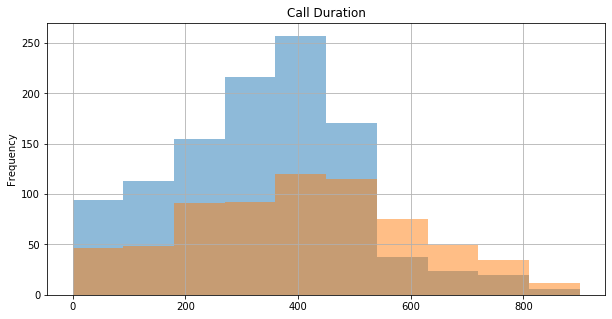

In [19]:
plt.figure(figsize=(10, 5))
df.groupby(by='plan')['duration'].plot(kind='hist', grid=True, range=(0, 900), alpha=0.5, title='Call Duration');

The plot shows that most users tend to use 200 to about 700 minutes each month. The graph looks similar to a bell curve but seems skewed to the right.

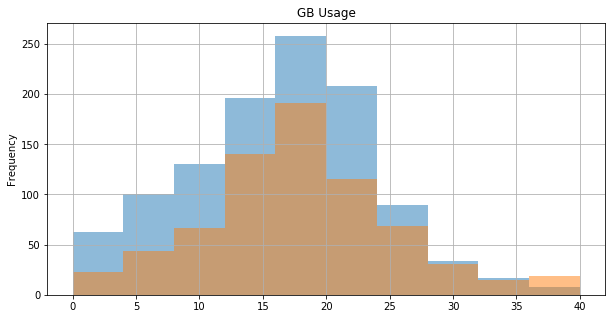

In [20]:
plt.figure(figsize=(10, 5))
df.groupby(by='plan')['gb_used'].plot(kind='hist', grid=True, range=(0, 40), alpha=0.5, title='GB Usage');

Most users tend to use 13 - 24 gbs per month of data. The users of the Ultimate plan use much more data comparatively. The graph shows a very good bell curve.

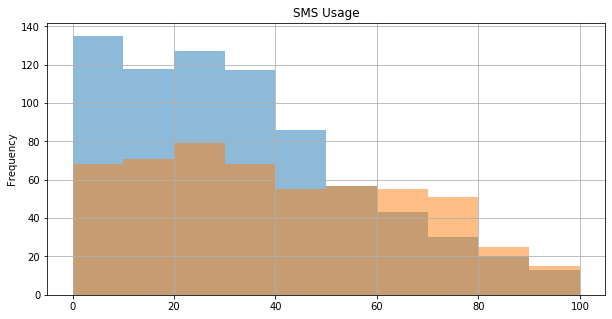

In [21]:
plt.figure(figsize=(10, 5))
df.groupby(by='plan')['messages_count'].plot(kind='hist', grid=True, range=(0, 100), alpha=0.5, title='SMS Usage');

Most all users fit between sending 0 to 40 messages per month. There are is significantly more SMS being used for users of the Ultimate plan. The graph is heavily skewed to the right.

In [22]:
df[['duration', 'gb_used', 'messages_count']].describe()

,duration,gb_used,messages_count
count,1811.000000,1830.000000,1359.000000
mean,376.004970,16.814754,40.512141
std,205.118692,7.881164,31.448833
min,0.000000,1.000000,1.000000
25%,238.500000,12.000000,16.000000
50%,370.000000,17.000000,33.000000
75%,478.000000,21.000000,58.000000
max,1369.000000,67.000000,180.000000


Here the mean and standard deviation is outlined.

### Conclusion

Overall users of the ultimate plan use their plans much more often, and tend to use more than twice as much.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Very good graphs!We can see the difference and compare plans.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
We should write more information about our graphs. Also we can write ideas why we have such graphs. :) 
</div>

## Testing the Hypothesis

Null hypothesis - The profit of each calling plan is the same.

Alternative hypotheses - Some calling plans are more profitable than the other.

In [23]:
results = st.ttest_ind(df.loc[df['plan'] == 'surf']['monthly_revenue'],
                       df.loc[df['plan'] == 'ultimate']['monthly_revenue'], equal_var=False, nan_policy = 'omit')

alpha = 0.05

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.0
We reject the null hypothesis


In [29]:
if df.loc[df['plan'] == 'surf']['monthly_revenue'].mean() < df.loc[df['plan'] == 'ultimate']['monthly_revenue'].mean():
    print('Ultimate plans make more profit')
else:
    print('Surf plans make more profit')

Ultimate plans make more profit


The null hypothesis is incorrect that each calling plan makes the same profit, and the Ultimate plan has shown to be better for the company.

Null hypothesis - The average profit from customers in the NY-NJ area the same as that of other regions.

Alternative hypotheses - The average profit from customers in the NY-NJ area is different from that of other regions.

In [33]:
results = st.ttest_ind(df.loc[df['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue'], 
                       df.loc[df['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue'], 
                       equal_var = False, nan_policy = 'omit')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  3.185540632040458e-10
We reject the null hypothesis


### Conclusion

Here our tests show that there is indeed a price difference between each plan and that the Ultimate plan makes more money. Additionally, there is a profit difference for those in the NY-NJ area as compared to other regions. The null hypothesis was rejected in both cases.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Excellent! Right formularation of hypothesys and test.
</div>

## Major Conclusion

Overall, our results indeed show a price difference between the two plans. The profit of the Ultimate plan is almost more than twice that of Surf, and the NY-NJ area has not shown to differ in profits compared to other regions. Through this we removed some rows of useless NaN's and cojoined each dataframe into one for easier calculations and plotted and analyzed the behavior of our users. Megaline's marketing should focus on the Ultimate plan and all regions.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Very good that we have thesis of our research. We always can write more. 
</div>